# Spatial data operations {#sec-spatial-operations}

## Prerequisites


In [1]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 6)
pd.options.display.max_colwidth = 35
plt.rcParams["figure.figsize"] = (5, 5)

Packages...


In [2]:
import shapely.geometry
import geopandas as gpd
import numpy as np
import os
import rasterio
import scipy.ndimage

from rasterio.plot import show

Let us load the sample data for this chapter:


In [3]:
#| echo: false
from pathlib import Path
data_path = Path("data")
file_path = Path("data/landsat.tif")
if not file_path.exists():
  if not data_path.is_dir():
     os.mkdir(data_path)
  print("Attempting to get the data")
  import requests
  r = requests.get("https://github.com/geocompr/py/releases/download/0.1/landsat.tif")  
  with open(file_path, "wb") as f:
    f.write(r.content)

In [4]:
nz = gpd.read_file("data/nz.gpkg")
nz_height = gpd.read_file("data/nz_height.gpkg")
world = gpd.read_file('data/world.gpkg')
src_elev = rasterio.open("data/elev.tif")
src_multi_rast = rasterio.open("data/landsat.tif")
src_grain = rasterio.open('data/grain.tif')

## Introduction

## Spatial operations on vector data {#sec-spatial-vec}

### Spatial subsetting

Spatial subsetting is the process of taking a spatial object and returning a new object containing only features that relate in space to another object. 
Analogous to attribute subsetting (covered in @sec-vector-attribute-subsetting), subsets of `GeoDataFrame`s can be created with square bracket (`[`) operator using the syntax `x[y]`, where `x` is an `GeoDataFrame` from which a subset of rows/features will be returned, and `y` is the 'subsetting object'. 
`y`, in turn, can be created using one of the binary geometry relation methods, such as `.intersects` (see @sec-topological-relations). 

To demonstrate spatial subsetting, we will use the `nz` and `nz_height` layers, which contain geographic data on the 16 main regions and 101 highest points in New Zealand, respectively (@fig-spatial-subset), in a projected coordinate system. 
The following lines of code create an object representing Canterbury (`canterbury`), then use spatial subsetting to return all high points in the region (`canterbury_height`):


In [5]:
canterbury = nz[nz['Name'] == 'Canterbury']
canterbury

,Name,Island,Land_area,...,Median_income,Sex_ratio,geometry
10,Canterbury,South,44504.499091,...,30100,0.975327,MULTIPOLYGON (((1686901.914 535...


In [6]:
# Does each 'nz_height' point intersect with 'canterbury'?
sel = nz_height.intersects(canterbury['geometry'].iloc[0])
sel

0      False
1      False
       ...  
99     False
100    False
Length: 101, dtype: bool

In [7]:
canterbury_height = nz_height[sel]
canterbury_height

,t50_fid,elevation,geometry
4,2362630,2749,POINT (1378169.600 5158491.453)
5,2362814,2822,POINT (1389460.041 5168749.086)
...,...,...,...
93,2380300,2711,POINT (1654213.379 5349962.973)
94,2380308,2885,POINT (1654898.622 5350462.779)


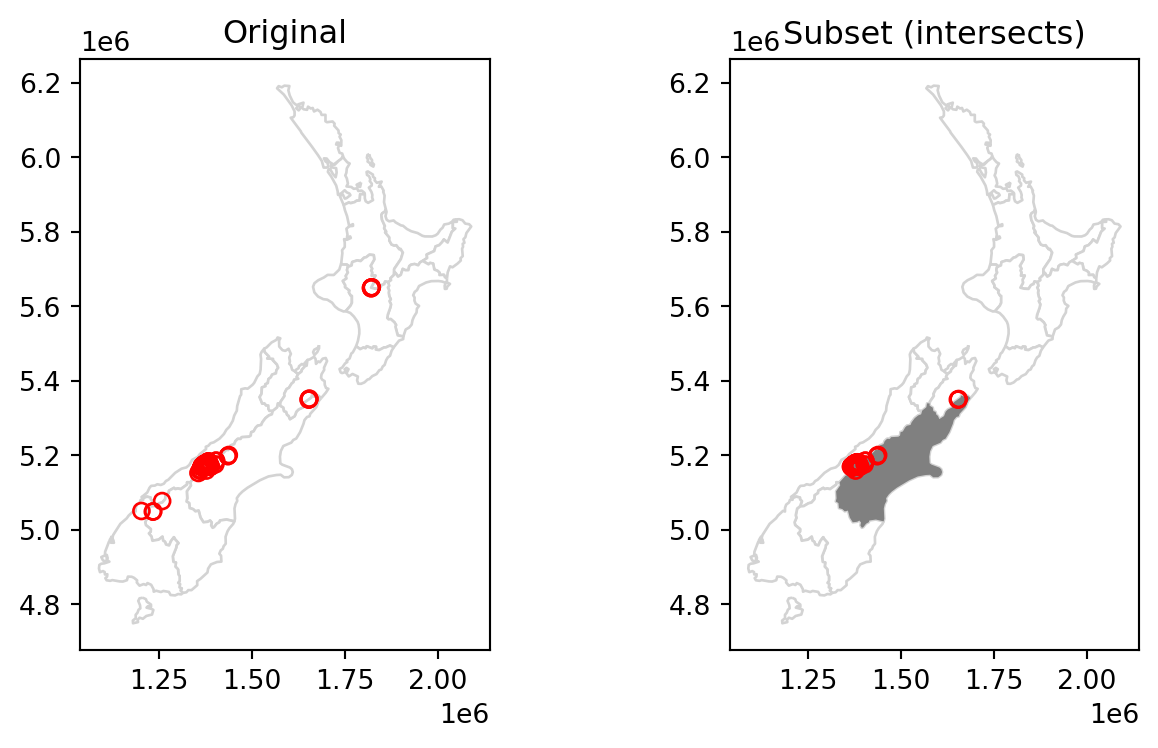

In [8]:
#| label: fig-spatial-subset
#| fig-cap: Spatial subsetting of points by intersection with polygon

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[0])
nz_height.plot(ax=base, color='None', edgecolor='red')
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[1])
canterbury.plot(ax=base, color='grey', edgecolor='none')
canterbury_height.plot(ax=base, color='None', edgecolor='red')
axes[0].set_title('Original')
axes[1].set_title('Subset (intersects)');

Like in attribute subsetting (@sec-vector-attribute-subsetting), we are using a boolean series (`sel`), of the same length as the number of rows in the filtered table (`nz_height`), created based on a condition applied on itself. 
The difference is that the condition is not a comparison of attribute values, but an evaluation of a spatial relation. 
Namely, we evaluate whether each geometry of `nz_height` intersects with `canterbury` geometry, using the `.intersects` method.

Various topological relations can be used for spatial subsetting which determine the type of spatial relationship that features in the target object must have with the subsetting object to be selected. 
These include touches, crosses or within, as we will see shortly in @sec-topological-relations. 
The most commonly used method `.intersects` method which we used in the last example is a 'catch all' topological relation, that will return features in the target that touch, cross or are within the source 'subsetting' object. 
Alternatively, we can evaluate other methods, such as `.disjoint` to obtain all points that *do not* intersect with Canterbury:


In [9]:
# Is each 'nz_height' point disjoint from 'canterbury'?
sel = nz_height.disjoint(canterbury['geometry'].iloc[0])
canterbury_height2 = nz_height[sel]

as shown in @fig-spatial-subset-disjoint:


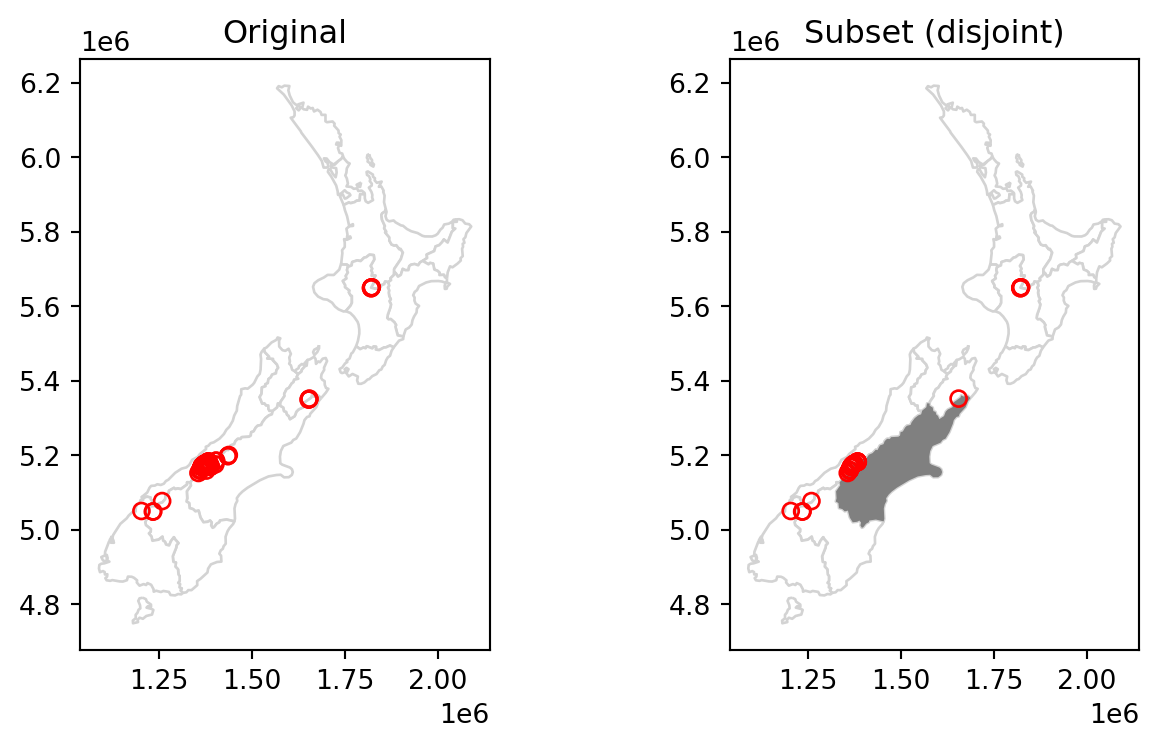

In [10]:
#| label: fig-spatial-subset-disjoint
#| fig-cap: Spatial subsetting of points disjoint from a polygon

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[0])
nz_height.plot(ax=base, color='None', edgecolor='red')
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[1])
canterbury.plot(ax=base, color='grey', edgecolor='none')
canterbury_height2.plot(ax=base, color='None', edgecolor='red');
axes[0].set_title('Original')
axes[1].set_title('Subset (disjoint)');

In case we need to subset according to several geometries at once, e.g., find out which points intersect with both Canterbury and Southland, we can dissolve the filtering subset before applying the `.intersects` (or any other) operator:


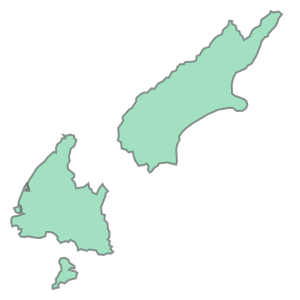

In [11]:
canterbury_southland = nz[(nz['Name'] == 'Canterbury') | (nz['Name'] == 'Southland')]
canterbury_southland = canterbury_southland.unary_union
canterbury_southland

In [12]:
sel = nz_height.intersects(canterbury_southland)
canterbury_southland_height = nz_height[sel]
canterbury_southland_height

,t50_fid,elevation,geometry
0,2353944,2723,POINT (1204142.603 5049971.287)
4,2362630,2749,POINT (1378169.600 5158491.453)
...,...,...,...
93,2380300,2711,POINT (1654213.379 5349962.973)
94,2380308,2885,POINT (1654898.622 5350462.779)


The resulting subset is shown in @fig-spatial-subset2:


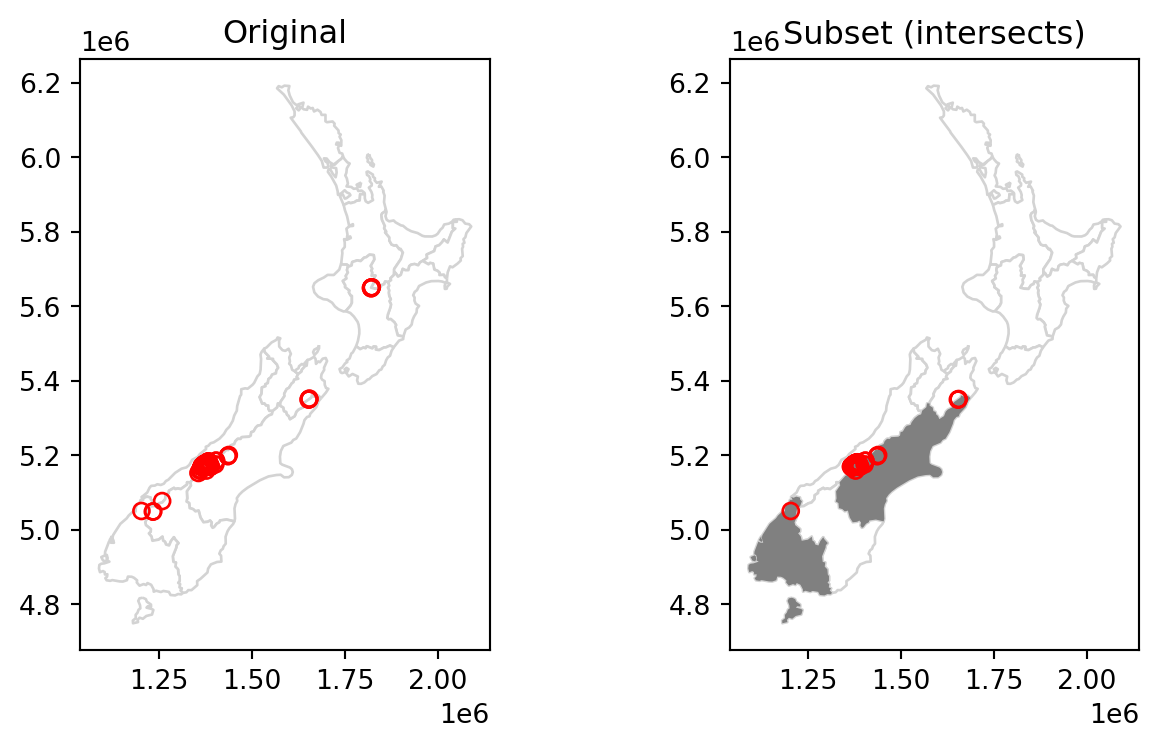

In [13]:
#| label: fig-spatial-subset2
#| fig-cap: Spatial subsetting of points by intersection with more that one polygon

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[0])
nz_height.plot(ax=base, color='None', edgecolor='red')
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[1])
gpd.GeoSeries(canterbury_southland).plot(ax=base, color='grey', edgecolor='none')
canterbury_southland_height.plot(ax=base, color='None', edgecolor='red')
axes[0].set_title('Original')
axes[1].set_title('Subset (intersects)');

The next section further explores different types of spatial relation, also known as binary predicates (of which `.intersects` and `.disjoint` are two examples), that can be used to identify whether or not two features are spatially related or not.

### Topological relations {#sec-topological-relations}

Topological relations describe the spatial relationships between objects. "Binary topological relationships", to give them their full name, are logical statements (in that the answer can only be `True` or `False`) about the spatial relationships between two objects defined by ordered sets of points (typically forming points, lines and polygons) in two or more dimensions (Egenhofer and Herring 1990). That may sound rather abstract and, indeed, the definition and classification of topological relations is based on mathematical foundations first published in book form in 1966 (Spanier 1995), with the field of algebraic topology continuing into the 21st century (Dieck 2008).

Despite their mathematical origins, topological relations can be understood intuitively with reference to visualizations of commonly used functions that test for common types of spatial relationships. Figure 4.2 shows a variety of geometry pairs and their associated relations. The third and fourth pairs in Figure 4.2 (from left to right and then down) demonstrate that, for some relations, order is important: while the relations equals, intersects, crosses, touches and overlaps are symmetrical, meaning that if function(x, y) is true, function(y, x) will also by true, relations in which the order of the geometries are important such as contains and within are not. Notice that each geometry pair has a “DE-9IM” string such as FF2F11212, described in the next section. 

![Topological relations between vector geometries, inspired by Figures 1 and 2 in Egenhofer and Herring (1990). The relations for which the function(x, y) is true are printed for each geometry pair, with x represented in pink and y represented in blue. The nature of the spatial relationship for each pair is described by the Dimensionally Extended 9-Intersection Model string. ](https://geocompr.robinlovelace.net/04-spatial-operations_files/figure-html/relations-1.png)

In `shapely`, functions testing for different types of topological relations are known as ["relationships"](https://shapely.readthedocs.io/en/stable/manual.html#relationships). To see how topological relations work in practice, let's create a simple reproducible example, building on the relations illustrated in Figure 4.2 and consolidating knowledge of how vector geometries are represented from a previous chapter (@sec-geometry-columns and @sec-geometries):


In [14]:
points = gpd.GeoSeries([
  shapely.geometry.Point(0.2,0.1), 
  shapely.geometry.Point(0.7,0.2), 
  shapely.geometry.Point(0.4,0.8)
])
line = gpd.GeoSeries([
  shapely.geometry.LineString([(0.4,0.2), (1,0.5)])
])
poly = gpd.GeoSeries([
  shapely.geometry.Polygon([(0,0), (0,1), (1,1), (1,0.5), (0,0)])
])

The resulting `GeoSeries` named `points`, `line`, and `poly` are visualized as follows:


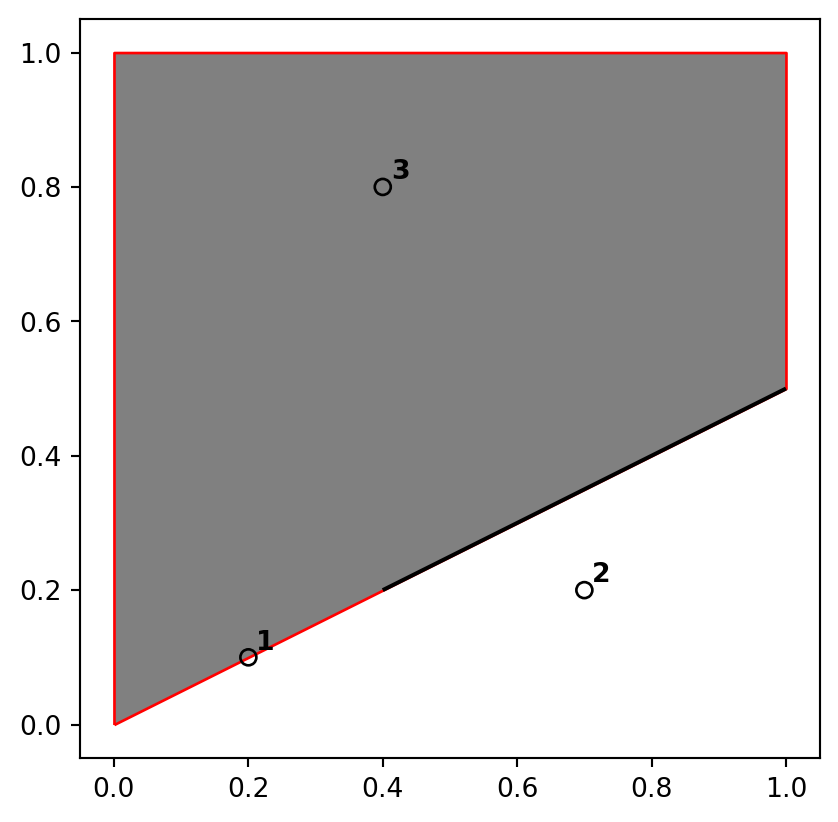

In [15]:
#| label: fig-spatial-relations-geoms
#| fig-cap: 'Points, line and polygon objects arranged to illustrate topological relations'

ax = gpd.GeoSeries(poly).plot(color='grey', edgecolor='red')
ax = gpd.GeoSeries(line).plot(ax=ax, color='black')
points.plot(ax=ax, color='none', edgecolor='black')
for x, y, label in zip(points.x, points.y, [1,2,3]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), weight='bold', textcoords="offset points")

A simple query is: which of the points in `points` intersect in some way with polygon `poly`? The question can be answered by inspection (points 1 and 3 are touching and within the polygon, respectively). This question can be answered with the `.intersects` method, as follows. Note that we evaluate the relation between each geometry in a `GeoSeries` (`points`) and a single `shapely` geometry (`poly.iloc[0]`). When both inputs are `GeoSeries`, a pairwise evaluation takes place between geometries aligned by index (`align=True`, the default) or by position (`align=False`):


In [16]:
points.intersects(poly.iloc[0])

0     True
1    False
2     True
dtype: bool

The result is a boolean `Series`. Its contents should match your intuition: positive (`True`) results are returned for the first and third point, and a negative result (`False`) for the second are outside the polygon's border.

Again, the above output is a `Series` where each value represents a feature in the first input (`points`). In case we need to obtain a matrix of *pairwise* results, we can use `.apply` as follows. In this case, the result is a `DataFrame`, where each row represents a `points` geometry and each column represents a `poly` geometry (there is just one, in this case)L


In [17]:
points.apply(lambda x: poly.intersects(x))

,0
0,True
1,False
2,True


`.intersects` returns `True` even in cases where the features just touch: intersects is a 'catch-all' topological operation which identifies many types of spatial relation, as illustrated in Figure 4.2. More restrictive questions include which points lie within the polygon, and which features are on or contain a shared boundary with it? These can be answered as follows:


In [18]:
points.within(poly.iloc[0])

0    False
1    False
2     True
dtype: bool

In [19]:
points.touches(poly.iloc[0])

0     True
1    False
2    False
dtype: bool

Note that although the first point touches the boundary polygon, it is not within it; the third point is within the polygon but does not touch any part of its border. The opposite of `.intersects` is `.disjoint`, which returns only objects that do not spatially relate in any way to the selecting object:


In [20]:
points.disjoint(poly.iloc[0])

0    False
1     True
2    False
dtype: bool

Another useful type of relation is "within distance", where we detect features that intersect with the target buffered by particular distance. Buffer distance determines how close target objects need to be before they are selected. This can be done by literally buffering (@sec-geometries) the target geometry, and evaluating intersection (`.intersects`, see above). Another way is to calculate the distances and compare them to the distance threshold:


In [21]:
points.distance(poly.iloc[0]) < 0.2

0    True
1    True
2    True
dtype: bool

Note that although point 2 is more than 0.2 units of distance from the nearest vertex of `poly`, it is still selected when the distance is set to 0.2. This is because distance is measured to the nearest edge, in this case the part of the the polygon that lies directly above point 2 in Figure 4.2. We can verify the actual distance between point 2 and the polygon is 0.13, as follows:


In [22]:
points.iloc[1].distance(poly.iloc[0])

0.13416407864998736

### DE-9IM strings

...



### Spatial joining

Joining two non-spatial datasets relies on a shared 'key' variable, as described in @sec-vector-attribute-joining. Spatial data joining applies the same concept, but instead relies on spatial relations, described in the previous section. As with attribute data, joining adds new columns to the target object (the argument x in joining functions), from a source object (y).

The process is illustrated by the following example: imagine you have ten points randomly distributed across the Earth's surface and you ask, for the points that are on land, which countries are they in? Implementing this idea in a reproducible example will build your geographic data handling skills and show how spatial joins work. The starting point is to create points that are randomly scattered over the Earth's surface:


In [23]:
np.random.seed(11)  ## set seed for reproducibility
bb = world.total_bounds  ## the world's bounds
x = np.random.uniform(low=bb[0], high=bb[2], size=10)
y = np.random.uniform(low=bb[1], high=bb[3], size=10)
random_points = gpd.points_from_xy(x, y, crs=4326)
random_points = gpd.GeoSeries(random_points)
random_points = gpd.GeoDataFrame({'geometry': random_points})
random_points

,geometry
0,POINT (-115.10291 36.78178)
1,POINT (-172.98891 -71.02938)
...,...
8,POINT (159.05039 -34.99599)
9,POINT (126.28622 -62.49509)


The scenario illustrated in @fig-spatial-join shows that the `random_points` object (top left) lacks attribute data, while the world (top right) has attributes, including country names shown for a sample of countries in the legend. Spatial joins are implemented with `gpd.sjoin`, as illustrated in the code chunk below. The output is the `random_joined` object which is illustrated in @fig-spatial-join (bottom left). Before creating the joined dataset, we use spatial subsetting to create world_random, which contains only countries that contain random points, to verify the number of country names returned in the joined dataset should be four (see the top right panel of @fig-spatial-join).


In [24]:
# Subset
world_random = world[world.intersects(random_points.unary_union)]
world_random

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
4,US,United States,North America,...,78.841463,51921.984639,MULTIPOLYGON (((-171.73166 63.7...
18,RU,Russian Federation,Europe,...,70.743659,25284.586202,MULTIPOLYGON (((-180.00000 64.9...
52,ML,Mali,Africa,...,57.007000,1865.160622,MULTIPOLYGON (((-11.51394 12.44...
159,AQ,Antarctica,Antarctica,...,NaN,NaN,MULTIPOLYGON (((-180.00000 -89....


In [25]:
# Spatial join
random_joined = gpd.sjoin(random_points, world, how='left')
random_joined

,geometry,index_right,iso_a2,...,pop,lifeExp,gdpPercap
0,POINT (-115.10291 36.78178),4.0,US,...,318622525.0,78.841463,51921.984639
1,POINT (-172.98891 -71.02938),NaN,NaN,...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8,POINT (159.05039 -34.99599),NaN,NaN,...,NaN,NaN,NaN
9,POINT (126.28622 -62.49509),NaN,NaN,...,NaN,NaN,NaN


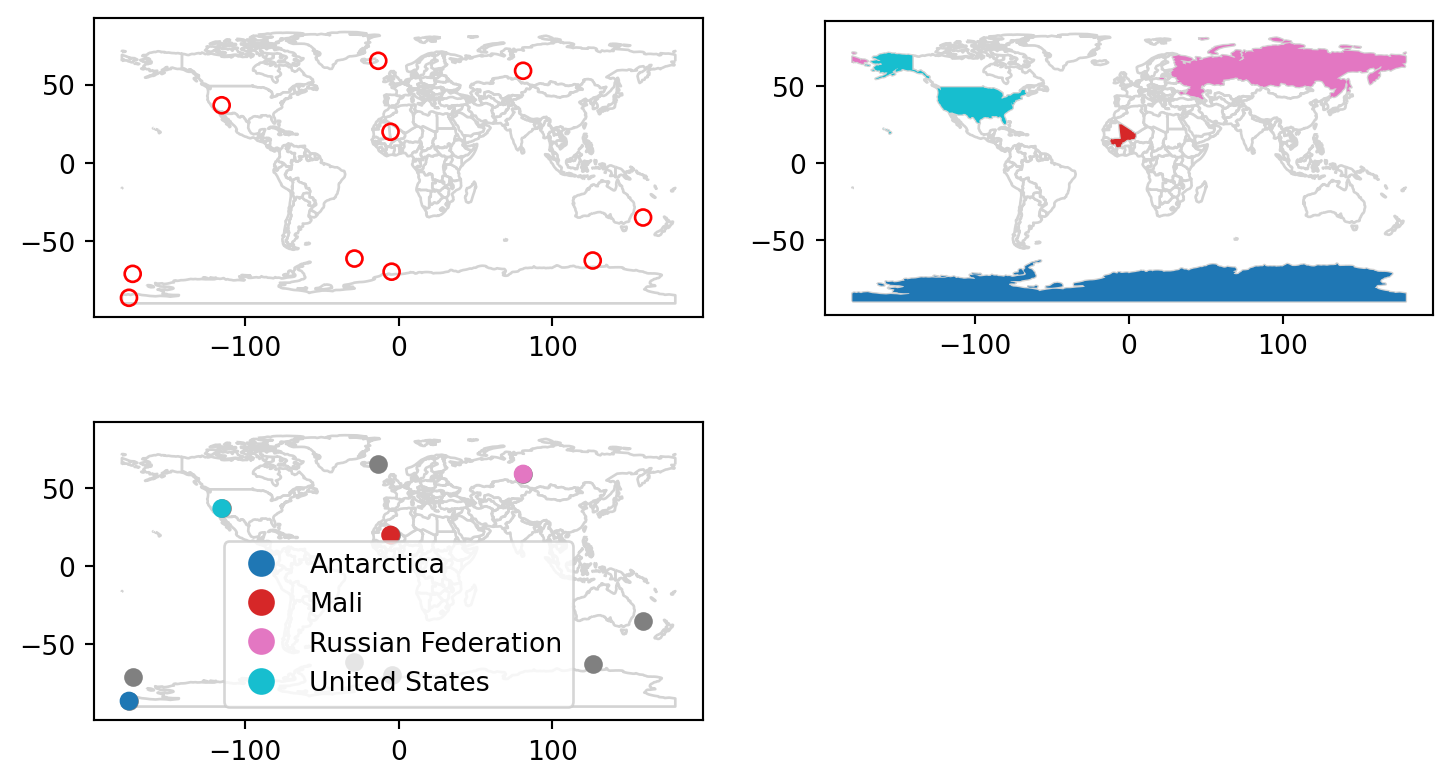

In [26]:
#| label: fig-spatial-join
#| fig-cap: Illustration of a spatial join. A new attribute variable is added to random points (top left) from source world object (top right) resulting in the data represented in the final panel.

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[0][0])
random_points.plot(ax=base, color='None', edgecolor='red')
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[0][1])
world_random.plot(ax=base, column='name_long')
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[1][0])
random_joined.geometry.plot(ax=base, color='grey');
random_joined.plot(ax=base, column='name_long', legend=True)
fig.delaxes(axes[1][1]);

### Non-overlapping joins

Sometimes two geographic datasets do not touch but still have a strong geographic relationship. The datasets `cycle_hire` and `cycle_hire_osm`, provide a good example. Plotting them shows that they are often closely related but they do not touch, as shown in ..., a base version of which is created with the following code below: 


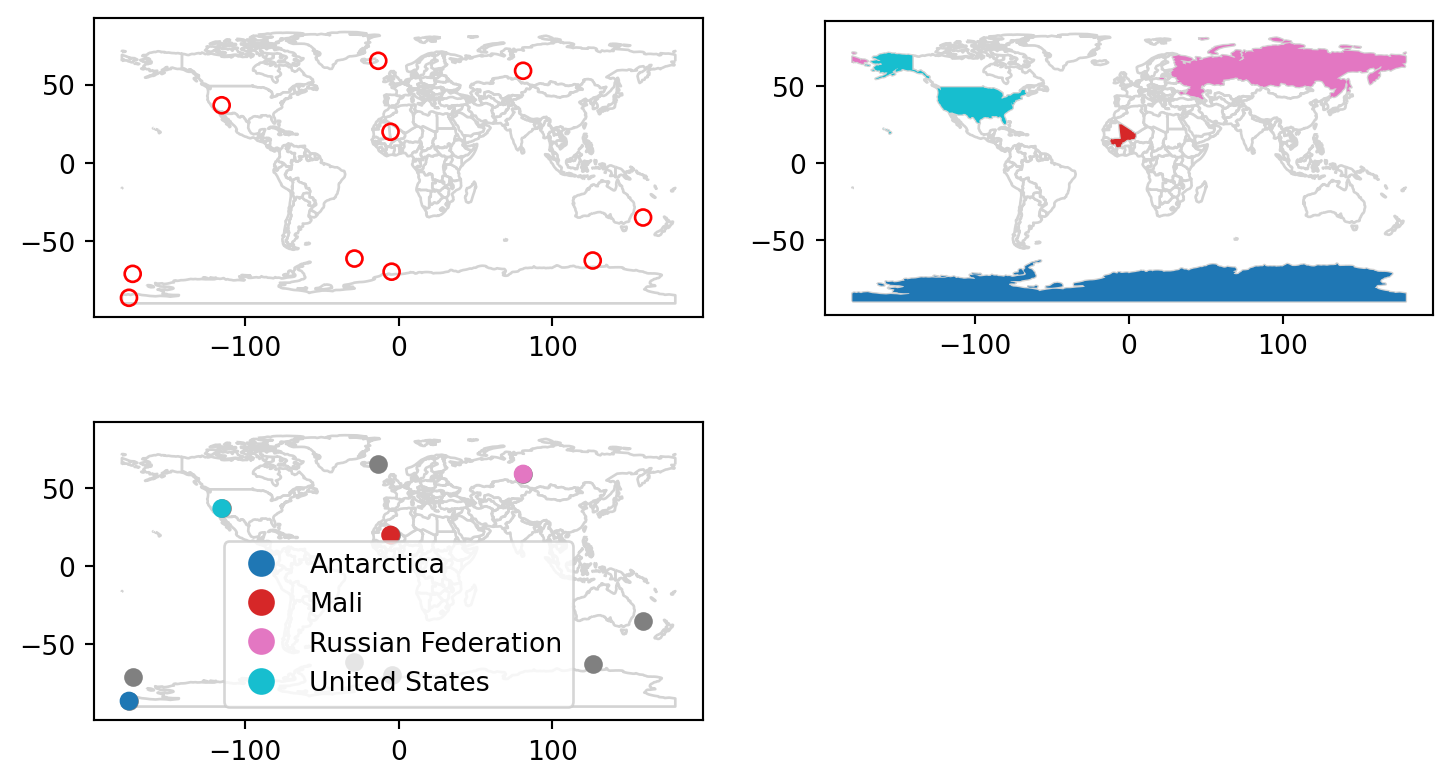

In [27]:
#| label: fig-spatial-join
#| fig-cap: Illustration of a spatial join. A new attribute variable is added to random points (top left) from source world object (top right) resulting in the data represented in the final panel.

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[0][0])
random_points.plot(ax=base, color='None', edgecolor='red')
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[0][1])
world_random.plot(ax=base, column='name_long')
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[1][0])
random_joined.geometry.plot(ax=base, color='grey');
random_joined.plot(ax=base, column='name_long', legend=True)
fig.delaxes(axes[1][1]);

### Spatial aggregation

As with attribute data aggregation, spatial data aggregation condenses data: aggregated outputs have fewer rows than non-aggregated inputs. 
Statistical aggregating functions, such as mean, average, or sum, summarise multiple values of a variable, and return a single value per grouping variable. 
@sec-vector-attribute-aggregation demonstrated how the `.groupby` method, combined with summary functions such as `.sum`, condense data based on attribute variables. 
This section shows how grouping by spatial objects can be acheived using spatial joins combined with non-spatial aggregation.

Returning to the example of New Zealand, imagine you want to find out the average height of high points in each region. 
It is the geometry of the source (`nz`) that defines how values in the target object (`nz_height`) are grouped. 
This can be done in three steps:

1. Figuring out which `nz` region each `nz_height` point falls in---using `gpd.sjoin`
2. Summarizing the average elevation per region---using `.groupby` and `.mean`
3. Joining the result back to `nz`---using `pd.merge`

First, we 'attach' the region classification of each point, using spatial join. 
Note that we are using the minimal set of columns required: the geometries (for the spatial join to work), the point elevation (to later calculate an average), and the region name (to use as key when joining the results back to `nz`).


In [28]:
nz_height2 = gpd.sjoin(
  nz_height[['elevation', 'geometry']], 
  nz[['Name', 'geometry']], 
  how='left'
)
nz_height2

,elevation,geometry,index_right,Name
0,2723,POINT (1204142.603 5049971.287),12,Southland
1,2820,POINT (1234725.325 5048309.302),11,Otago
...,...,...,...,...
99,2720,POINT (1822262.592 5650428.656),2,Waikato
100,2732,POINT (1822492.184 5650492.304),2,Waikato


Second, we calculate the average elevation:


In [29]:
nz_height3 = nz_height2.groupby('Name')[['elevation']].mean()
nz_height3

,elevation
Name,
Canterbury,2994.600000
Manawatu-Wanganui,2777.000000
...,...
Waikato,2734.333333
West Coast,2889.454545


The third and final step is joining the averages with the `nz` layer:


In [30]:
nz_height4 = pd.merge(nz[['Name', 'geometry']], nz_height3, on='Name', how='left')
nz_height4

,Name,geometry,elevation
0,Northland,MULTIPOLYGON (((1745493.196 600...,NaN
1,Auckland,MULTIPOLYGON (((1803822.103 590...,NaN
...,...,...,...
14,Nelson,MULTIPOLYGON (((1624866.279 541...,NaN
15,Marlborough,MULTIPOLYGON (((1686901.914 535...,2720.0


We now have create the `nz_height4` layer, which gives the average `nz_height` elevation value per polygon. The result is shown in @fig-nz-avg-nz-height. Note that the `missing_kwds` part determines the style of geometries where the symbology attribute (`elevation`) is missing, because the were no `nz_height` points overlapping with them. The default is to omit them, which is usually not what we want. With `{'color':'none','edgecolor':'black'}`, those polygons are shown with black outline and no fill.


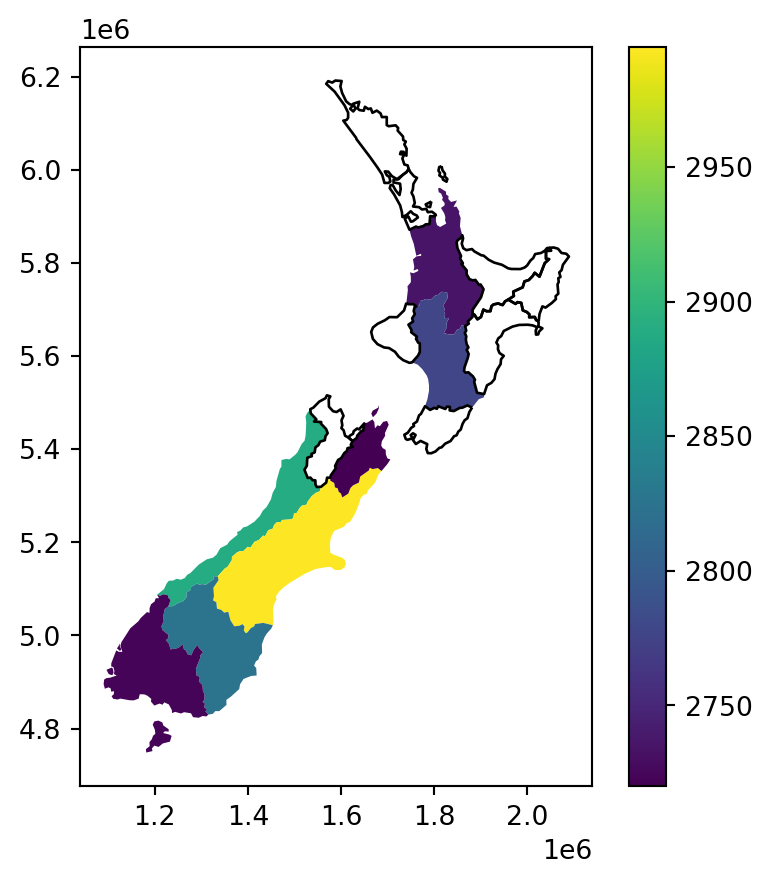

In [31]:
#| label: fig-nz-avg-nz-height
#| fig-cap: Average height of the top 101 high points across the regions of New Zealand

nz_height4.plot(
  column='elevation', 
  legend=True,
  missing_kwds={'color': 'none', 'edgecolor': 'black'}
);

### Joining incongruent layers

Spatial congruence is an important concept related to spatial aggregation. An aggregating object (which we will refer to as `y`) is congruent with the target object (`x`) if the two objects have shared borders. Often this is the case for administrative boundary data, whereby larger units---such as Middle Layer Super Output Areas (MSOAs) in the UK or districts in many other European countries---are composed of many smaller units.

Incongruent aggregating objects, by contrast, do not share common borders with the target (Qiu, Zhang, and Zhou 2012). This is problematic for spatial aggregation (and other spatial operations) illustrated in @fig-nz-and-grid: aggregating the centroid of each sub-zone will not return accurate results. Areal interpolation overcomes this issue by transferring values from one set of areal units to another, using a range of algorithms including simple area weighted approaches and more sophisticated approaches such as 'pycnophylactic' methods (Tobler 1979).

To demonstrate, we will create a "synthetic" layer comprising a [regular grid](https://gis.stackexchange.com/questions/322589/rasterizing-polygon-grid-in-python-geopandas-rasterio) of rectangles of size $100\times100$ $km$, covering the extent of the `nz` layer:


In [32]:
xmin, ymin, xmax, ymax = nz.total_bounds
res = 100000
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax+res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax+res)), res))
rows.reverse()
polygons = []
for x in cols:
    for y in rows:
        polygons.append( shapely.geometry.Polygon([(x,y), (x+res, y), (x+res, y-res), (x, y-res)]) )
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=nz.crs)
sel = grid.intersects(shapely.geometry.box(*nz.total_bounds))
grid = grid[sel]
grid['id'] = grid.index
grid

,geometry,id
0,POLYGON ((1090143.000 6248536.0...,0
1,POLYGON ((1090143.000 6148536.0...,1
...,...,...
157,POLYGON ((1990143.000 4948536.0...,157
158,POLYGON ((1990143.000 4848536.0...,158


as shown in @fig-nz-and-grid.


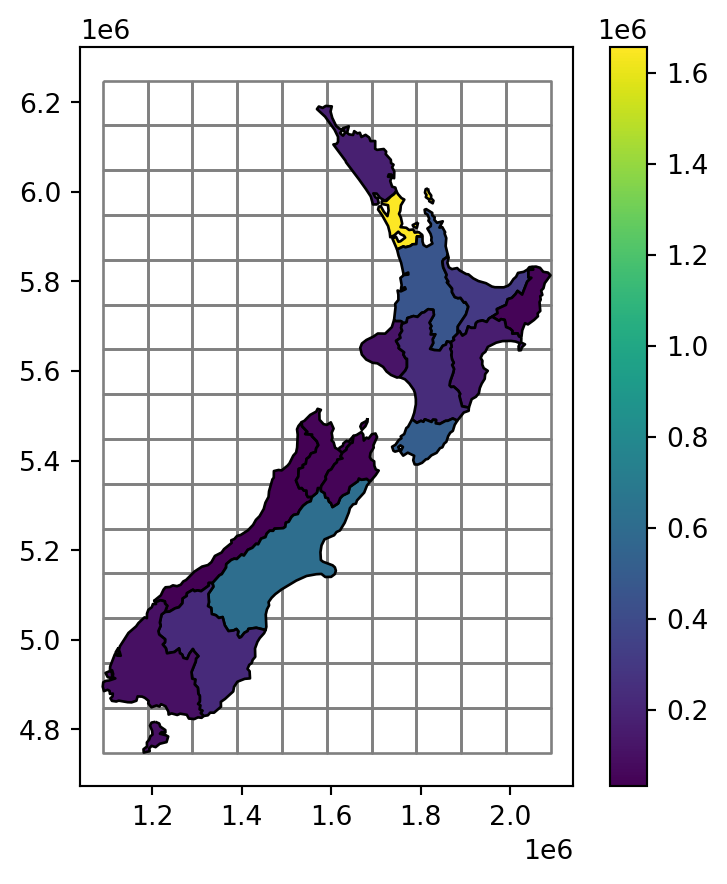

In [33]:
#| label: fig-nz-and-grid
#| fig-cap: The nz layer and a regular grid of rectangles

base = grid.plot(color='none', edgecolor='grey')
nz.plot(ax=base, column='Population', edgecolor='black', legend=True);

Our goal, now, is to "transfer" the `Population` attribute to the rectangular grid polygons, which is an example of a join between incongruent layers. To do that, we basically need to calculate--for each `grid` cell---the weighted sum of the population in `nz` polygons coinciding with that cell. The weights in the weighted sum calculation are the ratios between the area of the coinciding "part" out of the entire `nz` polygon. That is, we (inevitably) assume that the population in each `nz` polygon is equally distributed across space, therefore a partial `nz` polygon contains the respective partial population size.

We start with calculating the entire area of each `nz` polygon, as follows, using the `.area` method (see @sec-area-length):


In [34]:
nz['area'] = nz.area
nz

,Name,Island,Land_area,...,Sex_ratio,geometry,area
0,Northland,North,12500.561149,...,0.942453,MULTIPOLYGON (((1745493.196 600...,1.289058e+10
1,Auckland,North,4941.572557,...,0.944286,MULTIPOLYGON (((1803822.103 590...,4.911565e+09
...,...,...,...,...,...,...,...
14,Nelson,South,422.195242,...,0.925967,MULTIPOLYGON (((1624866.279 541...,4.080754e+08
15,Marlborough,South,10457.745485,...,0.957792,MULTIPOLYGON (((1686901.914 535...,1.046485e+10


Next, we use the `.overlay` method to calculate the pairwise intersections between `nz` and `grid`, hereby named `nz_grid`. We also calculate the area of the intersections, hereby named `area_sub`. If an `nz` polygon was completely within a single `grid` polygon, then `area_sub` is going to be equal to `area`; otherwise, it is going to be smaller:


In [35]:
nz_grid = nz.overlay(grid)
nz_grid = nz_grid[['id', 'area', 'Population', 'geometry']]
nz_grid['area_sub'] = nz_grid.area
nz_grid

,id,area,Population,geometry,area_sub
0,64,1.289058e+10,175500.0,POLYGON ((1586362.965 6168009.0...,3.231015e+08
1,80,1.289058e+10,175500.0,POLYGON ((1590143.000 6162776.6...,4.612641e+08
...,...,...,...,...,...
108,87,4.080754e+08,51400.0,POLYGON ((1649908.695 5455398.2...,1.716260e+07
109,87,1.046485e+10,46200.0,MULTIPOLYGON (((1678688.086 545...,4.526248e+08


We are going to elaborate on the `.overlay` method in...

The resulting layer `nz_grid` is shown in @fig-nz-and-grid2. 


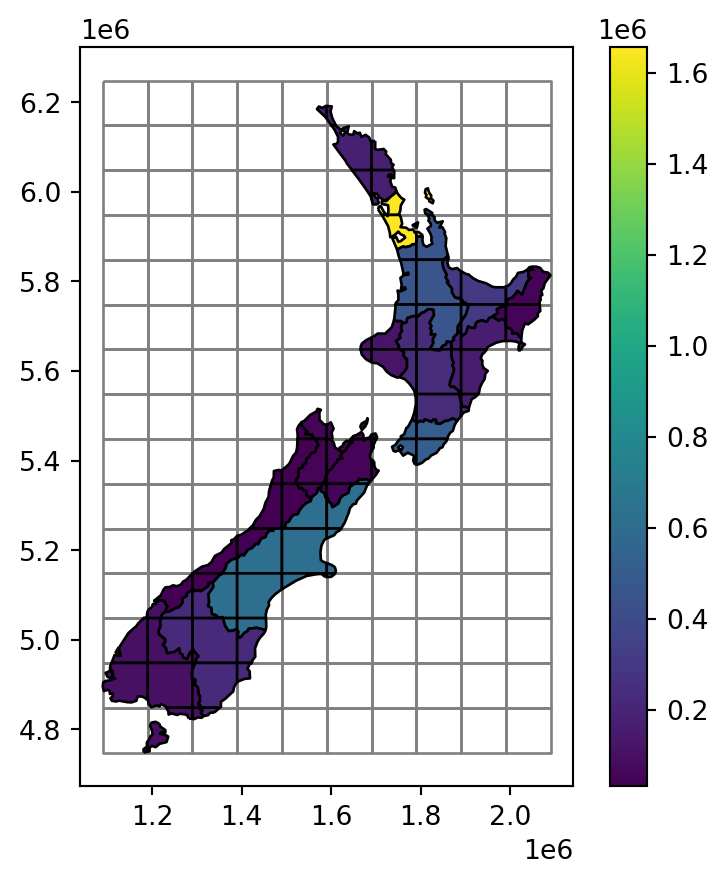

In [36]:
#| label: fig-nz-and-grid2
#| fig-cap: 'The nz layer and a regular grid of rectangles: after an overlay operation'

base = grid.plot(color='none', edgecolor='grey')
nz_grid.plot(ax=base, column='Population', edgecolor='black', legend=True);

Note that each of the "intersections" still holds the `Population` attribute of its "origin" feature of `nz`, as depicted in @fig-nz-and-grid2. The real population size of each `nz_grid` feature, however, is smaller (or equal), depending on the geographic area proportion that it occupies out of the original `nz` feature. To make the "correction", we first calculate the ratio (`area_prop`) and then multiply it by the population. The new (lowercase) attribute `population` now has the correct estimate of population sizes in `nz_grid`:


In [37]:
nz_grid['area_prop'] = nz_grid['area_sub'] / nz_grid['area']
nz_grid['population'] = nz_grid['Population'] * nz_grid['area_prop']
nz_grid

,id,area,Population,...,area_sub,area_prop,population
0,64,1.289058e+10,175500.0,...,3.231015e+08,0.025065,4398.897141
1,80,1.289058e+10,175500.0,...,4.612641e+08,0.035783,6279.925114
...,...,...,...,...,...,...,...
108,87,4.080754e+08,51400.0,...,1.716260e+07,0.042057,2161.752203
109,87,1.046485e+10,46200.0,...,4.526248e+08,0.043252,1998.239223


What is left to be done is to sum (see @sec-vector-attribute-aggregation) the population in all parts forming the same grid cell:


In [38]:
nz_grid = nz_grid.groupby('id')['population'].sum().reset_index()
nz_grid

,id,population
0,11,67.533590
1,12,15339.996965
...,...,...
55,149,31284.910446
56,150,129.326331


and join (see @sec-vector-attribute-joining) them back to the `grid` layer: 


In [39]:
grid = pd.merge(grid, nz_grid[['id', 'population']], on='id', how='left')
grid

,geometry,id,population
0,POLYGON ((1090143.000 6248536.0...,0,NaN
1,POLYGON ((1090143.000 6148536.0...,1,NaN
...,...,...,...
148,POLYGON ((1990143.000 4948536.0...,157,NaN
149,POLYGON ((1990143.000 4848536.0...,158,NaN


The final result `grid`, with the incongruently-joined `population` attribute from `nz`, is shown in @fig-nz-and-grid3. 


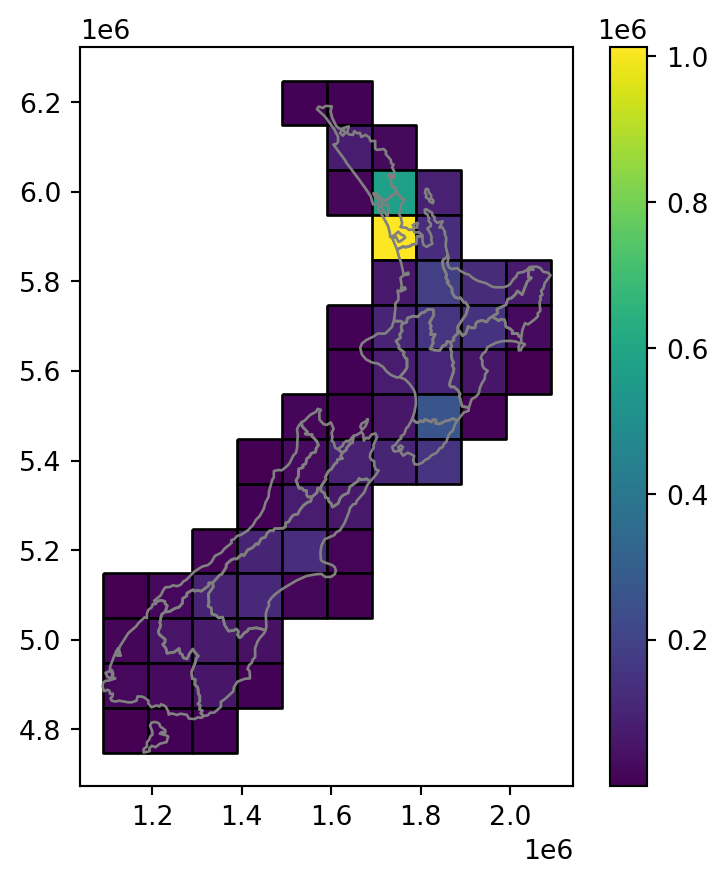

In [40]:
#| label: fig-nz-and-grid3
#| fig-cap: 'The nz layer and a regular grid of rectangles: final result'

base = grid.plot(column='population', edgecolor='black', legend=True);
nz.plot(ax=base, color='none', edgecolor='grey', legend=True);

We can demonstrate that, expectedly, the summed population in `nz` and `grid` is identical, even though the geometry is different (since we created `grid` to completely cover `nz`):


In [41]:
nz['Population'].sum()

4787200.0

In [42]:
grid['population'].sum()

4787199.999999998

The procedure in this section is known as an area-weighted interpolation of a spatially extensive (e.g., population) variable. An area-weighted interpolation of a spatially intensive variable (e.g., population density) is almost identical, except that we would have to calculate the weighted `.mean` rather than `.sum`, to preserve the average rather than the sum. 

### Distance relations

While topological relations are binary — a feature either intersects with another or does not — distance relations are continuous. The distance between two objects is calculated with the `distance` method. The method is applied on a `GeoSeries` (or a `GeoDataFrame`), with the argument being an individual `shapely` geometry. The result is a `Series` of pairwise distances.

This is illustrated in the code chunk below, which finds the distance between the three highest point in New Zealand:


In [43]:
nz_heighest = nz_height.sort_values(by='elevation', ascending=False).iloc[:3, :]
nz_heighest

,t50_fid,elevation,geometry
64,2372236,3724,POINT (1369317.630 5169132.284)
63,2372235,3717,POINT (1369512.866 5168235.616)
67,2372252,3688,POINT (1369381.942 5168761.875)


and the geographic centroid of the Canterbury region, created in Section 4.2.1: 


In [44]:
canterbury_centroid = canterbury.centroid.iloc[0]

Here are the distances:


In [45]:
nz_heighest.distance(canterbury_centroid)

64    115539.995747
63    115390.248038
67    115493.594066
dtype: float64

To obtain a distance matrix, i.e., a pairwise set of distances between all combinations of features in objects `x` and `y`, we need to use the `.apply` method. This is illustrated in the command below, which finds the distances between the first three features in `nz_height` and the Otago and Canterbury regions of New Zealand represented by the object `co`:


In [46]:
sel = nz['Name'].str.contains('Canter|Otag')
co = nz[sel]
co

,Name,Island,Land_area,...,Sex_ratio,geometry,area
10,Canterbury,South,44504.499091,...,0.975327,MULTIPOLYGON (((1686901.914 535...,4.532656e+10
11,Otago,South,31186.309188,...,0.951169,MULTIPOLYGON (((1335204.789 512...,3.190356e+10


The distance matrix `d` is obtained as follows (technically speaking, this is a `DataFrame`). In plain language, we take the geometry from each each row in `nz_height.iloc[:3, :]`, and apply the `.distance` method on `co` with that row as the argument:


In [47]:
d = nz_height.iloc[:3, :].apply(lambda x: co.distance(x['geometry']), axis=1)
d

,10,11
0,123537.158269,15497.717252
1,94282.773074,0.000000
2,93018.560814,0.000000


Note that the distance between the second and third features in `nz_height` and the second feature in `co` is zero. This demonstrates the fact that distances between points and polygons refer to the distance to any part of the polygon: The second and third points in `nz_height` are in Otago, which can be verified by plotting them:


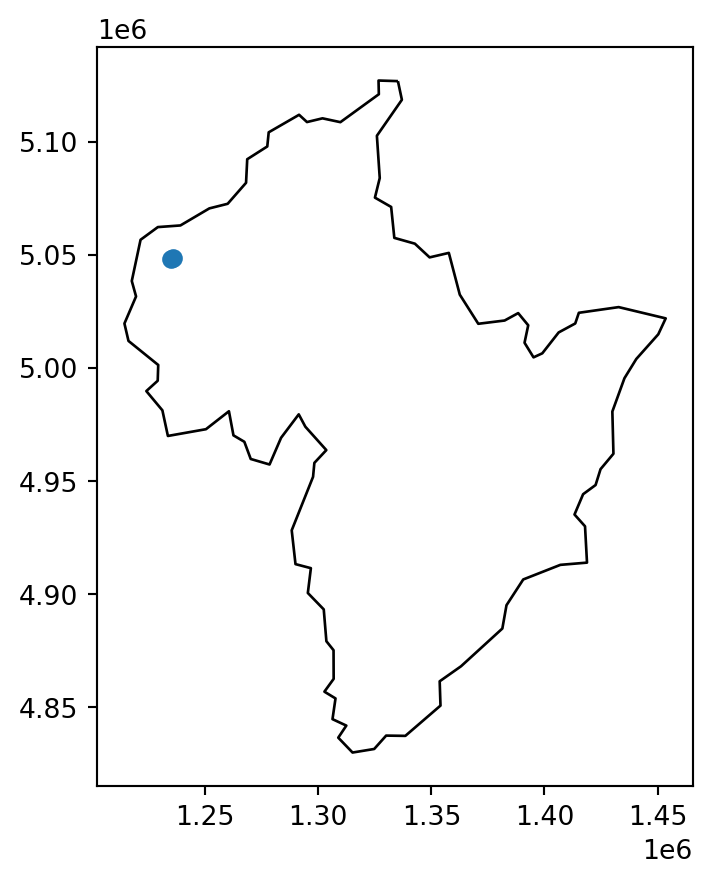

In [48]:
base = co.iloc[[1]].plot(color='none')
nz_height.iloc[1:3, :].plot(ax=base);

## Spatial operations on raster data {#spatial-ras}

### Spatial subsetting

The previous chapter (Section @sec-manipulating-raster-objects) demonstrated how to retrieve values associated with specific cell IDs or row and column combinations. Raster objects can also be extracted by location (coordinates) and other spatial objects. To use coordinates for subsetting, we can use the `.sample` method of a `rasterio` file connection object, combined with a list of coordinate tuples. The methods is demonstrated below to find the value of the cell that covers a point located at coordinates of 0.1, 0.1 in `elev`. The returned object is a *generator*: 


In [49]:
src_elev.sample([(0.1, 0.1)])

<generator object sample_gen at 0x7f6c12e04ba0>

In case we want all values at once we can apply `list`. The result is `16`:


In [50]:
list(src_elev.sample([(0.1, 0.1)]))

[array([16], dtype=uint8)]

Raster objects can also be subset with another raster object, as demonstrated in the code chunk below:

...


In [51]:
# ...

Another common use case of spatial subsetting is using a boolean mask, based on another raster with the same extent and resolution, or the original one, as illustrated in Figure .... To do that, we "erase" the values in the array of one raster, according to another corresponding "mask" raster. For example, let us read the `elev.tif` raster array: 


In [52]:
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

and create a correspinding random mask:


In [53]:
np.random.seed(1)
mask = np.random.choice([True, False], elev.shape)
mask

array([[False, False,  True,  True, False, False],
       [False, False, False,  True,  True, False],
       [ True, False, False,  True,  True, False],
       [ True,  True,  True, False,  True,  True],
       [False,  True,  True,  True, False,  True],
       [ True,  True, False, False, False, False]])

In the code chunk above, we have created a mask object called `mask` with values randomly assigned to `True` and `False`. Next, we want to keep those values of `elev` which are `False` in `mask` (i.e., they are *not* masked). In other words, we want to mask `elev` with `mask`. The result is stored in a copy named `elev1`. To be able to store `np.nan` in the raster, we also need to convert it to float (see @sec-summarizing-raster-objects):


In [54]:
elev1 = elev.copy()
elev1 = elev1.astype('float64')
elev1[mask] = np.nan
elev1

array([[ 1.,  2., nan, nan,  5.,  6.],
       [ 7.,  8.,  9., nan, nan, 12.],
       [nan, 14., 15., nan, nan, 18.],
       [nan, nan, nan, 22., nan, nan],
       [25., nan, nan, nan, 29., nan],
       [nan, nan, 33., 34., 35., 36.]])

The result is shown in @fig-raster-subset.


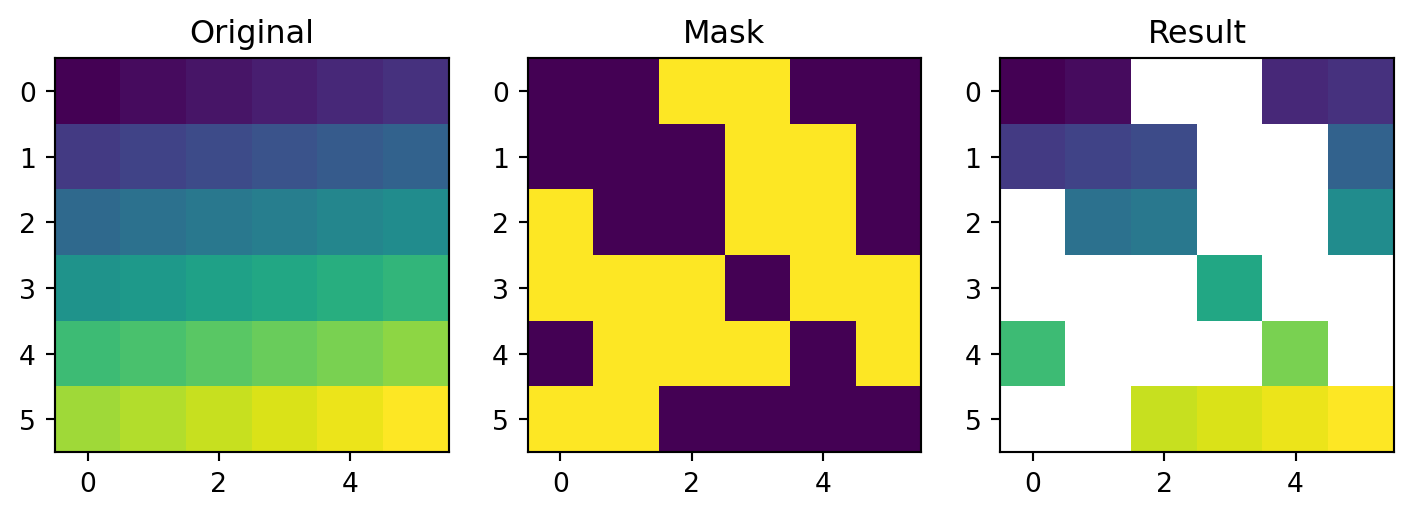

In [55]:
#| label: fig-raster-subset
#| fig-cap: Original raster (left). Raster mask (middle). Output of masking a raster (right).

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
show(elev, ax=axes[0])
show(mask, ax=axes[1])
show(elev1, ax=axes[2])
axes[0].set_title("Original")
axes[1].set_title("Mask")
axes[2].set_title("Result");

The above approach can be also used to replace some values (e.g., expected to be wrong) with `nan`:


In [56]:
elev1 = elev.copy()
elev1 = elev1.astype('float64')
elev1[elev1 < 20] = np.nan
elev1

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, 20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29., 30.],
       [31., 32., 33., 34., 35., 36.]])

These operations are in fact Boolean local operations, since we compare cell-wise two rasters. The next subsection explores these and related operations in more detail.

### Map algebra {#sec-map-algebra}

The term 'map algebra' was coined in the late 1970s to describe a "set of conventions, capabilities, and techniques" for the analysis of geographic raster and (although less prominently) vector data (Tomlin 1994). In this context, we define map algebra more narrowly, as operations that modify or summarise raster cell values, with reference to surrounding cells, zones, or statistical functions that apply to every cell.

Map algebra operations tend to be fast, because raster datasets only implicitly store coordinates, hence the old adage “raster is faster but vector is corrector”. The location of cells in raster datasets can be calculated by using its matrix position and the resolution and origin of the dataset (stored in the header). For the processing, however, the geographic position of a cell is barely relevant as long as we make sure that the cell position is still the same after the processing. Additionally, if two or more raster datasets share the same extent, projection and resolution, one could treat them as matrices for the processing.

This is the way that map algebra works with the terra package. First, the headers of the raster datasets are queried and (in cases where map algebra operations work on more than one dataset) checked to ensure the datasets are compatible. Second, map algebra retains the so-called one-to-one locational correspondence, meaning that cells cannot move. This differs from matrix algebra, in which values change position, for example when multiplying or dividing matrices.

Map algebra (or cartographic modeling with raster data) divides raster operations into four subclasses (Tomlin 1990), with each working on one or several grids simultaneously:

* Local or per-cell operations
* Focal or neighborhood operations. Most often the output cell value is the result of a 3 x 3 input cell block
* Zonal operations are similar to focal operations, but the surrounding pixel grid on which new values are computed can have irregular sizes and shapes
* Global or per-raster operations; that means the output cell derives its value potentially from one or several entire rasters

This typology classifies map algebra operations by the number of cells used for each pixel processing step and the type of the output. For the sake of completeness, we should mention that raster operations can also be classified by discipline such as terrain, hydrological analysis, or image classification. The following sections explain how each type of map algebra operations can be used, with reference to worked examples.

### Local operations {#sec-raster-local-operations}

Local operations comprise all cell-by-cell operations in one or several layers. 
Raster algebra is a classical use case of local operations - this includes adding or subtracting values from a raster, squaring and multipling rasters. 
Raster algebra also allows logical operations such as finding all raster cells that are greater than a specific value (5 in our example below). 
Local operations are applied using the `numpy` array operations syntax, as demonstrated below:

First, we need to read raster values:


In [57]:
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

Now, any element-wise array operation can be applied. For example:


In [58]:
elev + elev

array([[ 2,  4,  6,  8, 10, 12],
       [14, 16, 18, 20, 22, 24],
       [26, 28, 30, 32, 34, 36],
       [38, 40, 42, 44, 46, 48],
       [50, 52, 54, 56, 58, 60],
       [62, 64, 66, 68, 70, 72]], dtype=uint8)

@fig-raster-local-operations demonstrates a few more examples.


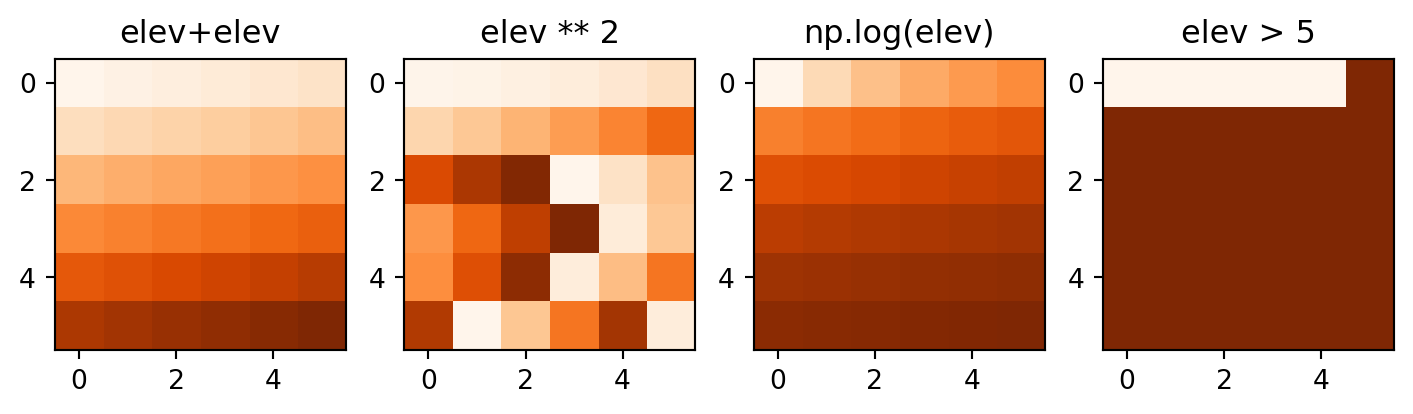

In [59]:
#| label: fig-raster-local-operations
#| fig-cap: 'Examples of different local operations of the elev raster object: adding two rasters, squaring, applying logarithmic transformation, and performing a logical operation.'

fig, axes = plt.subplots(ncols=4, figsize=(9,5))
show(elev + elev, ax=axes[0], cmap="Oranges")
show(elev ** 2, ax=axes[1], cmap="Oranges")
show(np.log(elev), ax=axes[2], cmap="Oranges")
show(elev > 5, ax=axes[3], cmap="Oranges")
axes[0].set_title("elev+elev")
axes[1].set_title("elev ** 2")
axes[2].set_title("np.log(elev)")
axes[3].set_title("elev > 5");

Another good example of local operations is the classification of intervals of numeric values into groups such as grouping a digital elevation model into low (class 1), middle (class 2) and high elevations (class 3). Here, we assign the raster values in the ranges 0–12, 12–24 and 24–36 are reclassified to take values 1, 2 and 3, respectively.


In [60]:
recl = elev.copy()
recl[(elev > 0)  & (elev <= 12)] = 1
recl[(elev > 12) & (elev <= 24)] = 2
recl[(elev > 24) & (elev <= 36)] = 3

The reclassified result is shown in @fig-raster-reclassify.


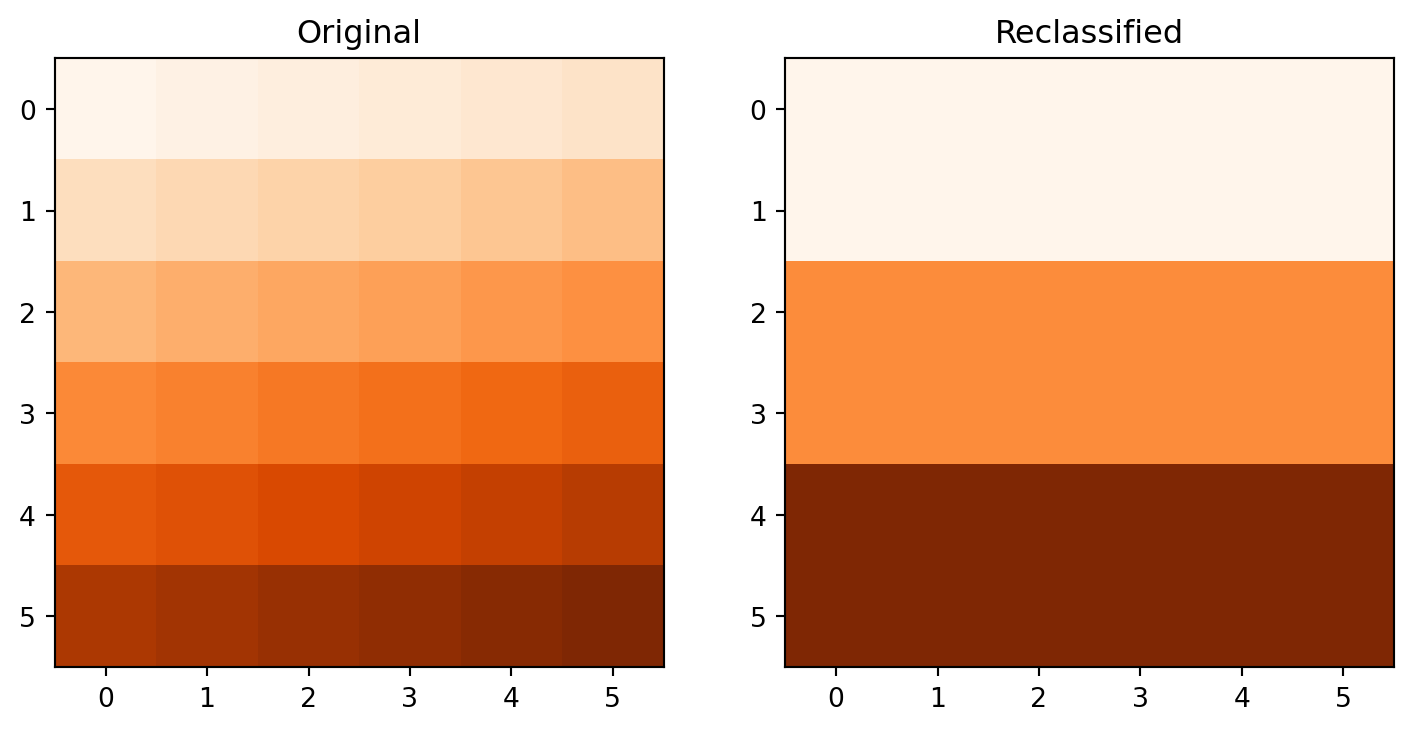

In [61]:
#| label: fig-raster-reclassify
#| fig-cap: Reclassifying a continuous raster into three categories.

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(elev, ax=axes[0], cmap="Oranges")
show(recl, ax=axes[1], cmap="Oranges")
axes[0].set_title("Original")
axes[1].set_title("Reclassified");

The calculation of the normalized difference vegetation index (NDVI) is a well-known local (pixel-by-pixel) raster operation. It returns a raster with values between -1 and 1; positive values indicate the presence of living plants (mostly > 0.2). NDVI is calculated from red and near-infrared (NIR) bands of remotely sensed imagery, typically from satellite systems such as Landsat or Sentinel. Vegetation absorbs light heavily in the visible light spectrum, and especially in the red channel, while reflecting NIR light, explaining the NVDI formula:

$$NDVI=\frac{NIR-Red} {NIR+Red}$$

Let's calculate NDVI for the multispectral satellite file of the Zion National Park.


In [62]:
multi_rast = src_multi_rast.read()
nir = multi_rast[3,:,:]
red = multi_rast[2,:,:]
ndvi = (nir-red)/(nir+red)

Convert values >1 to "No Data":


In [63]:
ndvi[ndvi>1] = np.nan

When plotting an RGB image using the `show` function, the function assumes that:

* Values are in the range `[0,1]` for floats, or `[0,255]` for integers (otherwise clipped)
* The order of bands is RGB

To "prepare" the multi-band raster for `show`, we therefore reverse the order of bands (which is originally BGR+NIR), and divided by the maximum to set the maximum value at `1`:


In [64]:
multi_rast_rgb = multi_rast[(2,1,0), :, :] / multi_rast.max()

The result is shown in @fig-raster-ndvi.


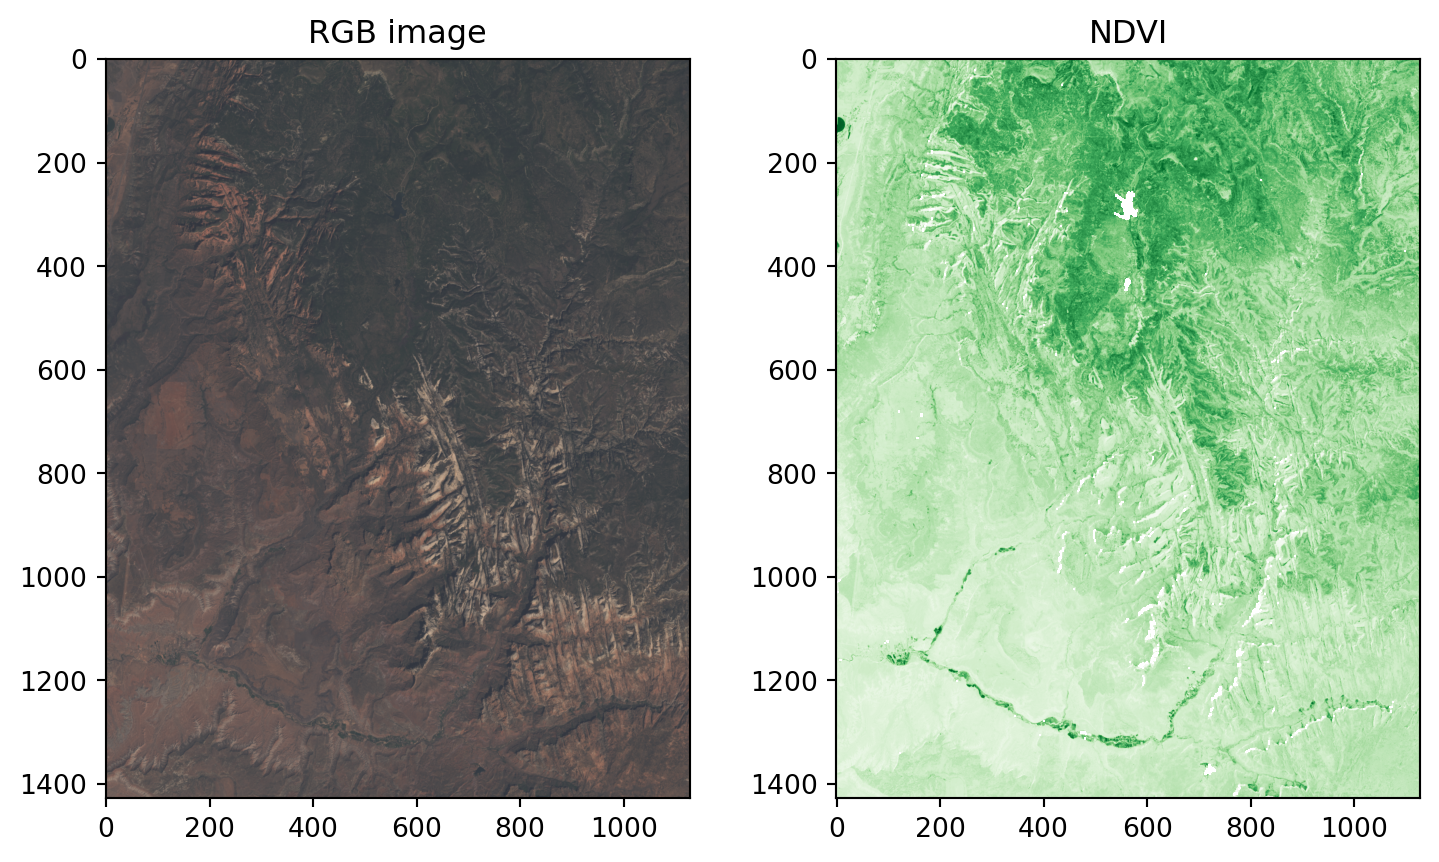

In [65]:
#| label: fig-raster-ndvi
#| fig-cap: RGB image (left) and NDVI values (right) calculated for the example satellite file of the Zion National Park.

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(multi_rast_rgb, ax=axes[0], cmap="RdYlGn")
show(ndvi, ax=axes[1], cmap="Greens")
axes[0].set_title("RGB image")
axes[1].set_title("NDVI");

### Focal operations

While local functions operate on one cell, though possibly from multiple layers, focal operations take into account a central (focal) cell and its neighbors. 
The neighborhood (also named kernel, filter or moving window) under consideration is typically of size 3-by-3 cells (that is the central cell and its eight surrounding neighbors), but can take on any other (not necessarily rectangular) shape as defined by the user. 
A focal operation applies an aggregation function to all cells within the specified neighborhood, uses the corresponding output as the new value for the the central cell, and moves on to the next central cell (Figure ...). 
Other names for this operation are spatial filtering and convolution (Burrough, McDonnell, and Lloyd 2015).

In Python, the `scipy.ndimage` package has a comprehensive collection of [functions](https://docs.scipy.org/doc/scipy/reference/ndimage.html#filters) to perform filtering of `numpy` arrays, such as:

* `minimum_filter`
* `maximum_filter`
* `uniform_filter` (i.e., mean filter)
* `median_filter`
etc.

In this group of functions, we define the shape of the moving window with either one of:

* `size`—a single number or tuple, implying a filter of those dimensions
* `footprint`—a boolean array, representing both the window shape and the identity of elements being included

In addition to specific built-in filters, 

* `convolve` applies the sum function after multiplying by a custom `weights` array
* `generic_filter` makes it possible to pass any custom function, where the user can specify any type of custom window-based calculatio.

For example, here we apply the minimum filter with window size of `3` on `elev`: 


In [66]:
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

In [67]:
elev_min = scipy.ndimage.minimum_filter(elev, size=3)
elev_min

array([[ 1,  1,  2,  3,  4,  5],
       [ 1,  1,  2,  3,  4,  5],
       [ 7,  7,  8,  9, 10, 11],
       [13, 13, 14, 15, 16, 17],
       [19, 19, 20, 21, 22, 23],
       [25, 25, 26, 27, 28, 29]], dtype=uint8)

Special care should be given to the edge pixels. How should they be calculated? `scipy.ndimage` gives several options through the `mode` parameter:

* `reflect` (the default)
* `constant`
* `nearest`
* `mirror`
* `wrap`

Sometimes artificially extending raster edges is considered unsuitable. 
In other words, we may wish the resulting raster to contain pixel values with "complete" windows only, for example to have a uniform sample size or because values in all directions matter (such as in topographic calculations). 
There is no specific option *not* to extend edges in `scipy.ndimage`. 
However, to get the same effect, the edges of the filtered array can be assigned with `nan`, in a number of rows and columns according to filter size. 
For example, when using a filter of `size=3`, the first "layer" of pixels may be assigned with `nan`, reflecting the fact that these pixels have incomplete 3*3 neighborhoods:


In [68]:
elev_min = elev_min.astype('float')
elev_min[:, [0, -1]] = np.nan
elev_min[[0, -1], :] = np.nan
elev_min

array([[nan, nan, nan, nan, nan, nan],
       [nan,  1.,  2.,  3.,  4., nan],
       [nan,  7.,  8.,  9., 10., nan],
       [nan, 13., 14., 15., 16., nan],
       [nan, 19., 20., 21., 22., nan],
       [nan, nan, nan, nan, nan, nan]])

We can quickly check if the output meets our expectations. 
In our example, the minimum value has to be always the upper left corner of the moving window (remember we have created the input raster by row-wise incrementing the cell values by one starting at the upper left corner). 

Focal functions or filters play a dominant role in image processing. Low-pass or smoothing filters use the mean function to remove extremes. 
In the case of categorical data, we can replace the mean with the mode, which is the most common value. 
By contrast, high-pass filters accentuate features. The line detection Laplace and Sobel filters might serve as an example here. 

Terrain processing, the calculation of topographic characteristics such as slope, aspect and flow directions, relies on focal functions. 
The `TerrainAttribute` function from package `richdem` can be used to calculate common [metrics](https://richdem.readthedocs.io/en/latest/python_api.html?highlight=TerrainAttribute#richdem.TerrainAttribute), specified through the `attrib` argument, namely:

* `slope_riserun` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_percentage` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_degrees` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_radians` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `aspect` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107
* `planform_curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107
* `profile_curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107

### Zonal operations

Just like focal operations, zonal operations apply an aggregation function to multiple raster cells. 
However, a second raster, usually with categorical values, defines the zonal filters (or 'zones') in the case of zonal operations, as opposed to a predefined neighborhood window in the case of focal operation presented in the previous section. 
Consequently, raster cells defining the zonal filter do not necessarily have to be neighbors. 
Our grain size raster is a good example, as illustrated in the right panel of Figure 3.2: different grain sizes are spread irregularly throughout the raster. 
Finally, the result of a zonal operation is a summary table grouped by zone which is why this operation is also known as zonal statistics in the GIS world. This is in contrast to focal operations which return a raster object.

To demonstrate, let us get back to the `grain` and `elev` rasters (Figure 3.2). To calculate zonal statistics, we use the arrays with raster values. The `elev` array was already imported earlier:


In [69]:
grain = src_grain.read(1)
grain

array([[1, 0, 1, 2, 2, 2],
       [0, 2, 0, 0, 2, 1],
       [0, 2, 2, 0, 0, 2],
       [0, 0, 1, 1, 1, 1],
       [1, 1, 1, 2, 1, 1],
       [2, 1, 2, 2, 0, 2]], dtype=uint8)

Our interntion is to calculate the average (or any other summary function, for that matter) of *elevation* in each zone defined by *grain* values. First, we can obtain the unique values defining the zones using `np.unique`: 


In [70]:
np.unique(grain)

array([0, 1, 2], dtype=uint8)

Now, we can use [dictionary conprehension](https://stackoverflow.com/questions/14507591/python-dictionary-comprehension) to "split" the `elev` array into separate one-dimensional arrays with values per `grain` group, with keys being the unique `grain` values:


In [71]:
z = {i: elev[grain == i] for i in np.unique(grain)}
z

{0: array([ 2,  7,  9, 10, 13, 16, 17, 19, 20, 35], dtype=uint8),
 1: array([ 1,  3, 12, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32], dtype=uint8),
 2: array([ 4,  5,  6,  8, 11, 14, 15, 18, 28, 31, 33, 34, 36], dtype=uint8)}

At this stage, we can expand the dictionary comprehension expression to calculate the mean elevation associated with each grain size class. Instead of placing the elevation values (`elev[grain==i]`) into the dictionary values, we place their mean (`elev[grain==i].mean()`):


In [72]:
z = {i: elev[grain == i].mean() for i in np.unique(grain)}
z

{0: 14.8, 1: 21.153846153846153, 2: 18.692307692307693}

This returns the statistics for each category, here the mean elevation for each grain size class. For example, the mean elevation in pixels characterized by grain size `0` is `14.8`, and so on.

### Global operations and distances

...

### Map algebra counterparts in vector processing

...

### Merging rasters

...

## Exercises

* Write a function which accepts and array and an `int` specifying the number of rows/columns to erase along an array edges. The function needs to return the modified array with `nan` values along its edges.
